In [42]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Transformer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from typing import List
# from torch.nn.functional import pad, log_softmax


from sklearn.model_selection import train_test_split




In [43]:
SRC_LANGUAGE = 'zh'
TGT_LANGUAGE = 'tl'
# Place-holdersa
token_transform = {}
vocab_transform = {}


In [44]:
def isEng(word):
    ascii = ord(word)
    if (ascii >= 65 and ascii <= 90) or (ascii >= 97 and ascii <= 122):
        return True
    return False

def zh_single_word_tokenize(string):
    single_word_list = []
    eng_str = ""
    for s in string:
        if ord(s) == 32: continue #space
        if isEng(s): eng_str += s
        else:
            if len(eng_str) > 0:
                single_word_list.append(eng_str)
                eng_str = ""
            single_word_list.append(s)
        
    return single_word_list


def tl_single_word_tokenize(string):
    single_word_list = []
    string = string.split()
    for s in string:
        rm_dil = s.split("-")
        for c in rm_dil: single_word_list.append(c)

    return single_word_list

In [45]:
zh_data = pd.read_csv("data/train-ZH.csv")
tl_data = pd.read_csv("data/train-TL.csv")

In [46]:
zh_list = []
tl_list = []
for i in range(zh_data.shape[0]):
    zh_list.append(zh_single_word_tokenize(zh_data["txt"][i]))
    tl_list.append(tl_single_word_tokenize(tl_data["txt"][i]))

In [47]:
class TranslationDataset(Dataset):
  def __init__(self, zh_list, tl_list):

    self.zh_tokens = zh_list
    self.tl_tokens = tl_list

  def __getitem__(self, index):
    return self.zh_tokens[index], self.tl_tokens[index]

  def __len__(self):
    return len(self.zh_tokens)
  

In [48]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
vocab_transform["zh"] = build_vocab_from_iterator(zh_list,min_freq=1,specials=special_symbols,special_first=True)
vocab_transform["tl"] = build_vocab_from_iterator(tl_list,min_freq=1,specials=special_symbols,special_first=True)
vocab_transform["zh"].set_default_index(UNK_IDX)
vocab_transform["tl"].set_default_index(UNK_IDX)

In [49]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [50]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [51]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [52]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(#token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        # print(src_sample)
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [53]:
def train_epoch(model, optimizer, train_dataloader):
    model.train()
    losses = 0

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model, val_dataloader):
    model.eval()
    losses = 0

    # val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [54]:
seed = 42
batch_size = 128
epochs = 20
lr = 1e-3
valid_prob = 0.2

In [55]:
print("Initializing dataset...")
dataset = TranslationDataset(zh_list, tl_list)

n = len(dataset)
valid_size = int(n * valid_prob)
train_ids , valid_ids = train_test_split(
 np.linspace(0, n - 1, n).astype("int"),
 test_size = valid_size,
 random_state = seed,
)

from torch.utils.data import Subset
train_dataset = Subset(dataset, train_ids)
valid_dataset = Subset(dataset, valid_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


Initializing dataset...


Epoch: 1, Train loss: 4.519, Val loss: 1.610, Epoch time = 16.961s
Epoch: 2, Train loss: 1.221, Val loss: 0.531, Epoch time = 16.997s
Epoch: 3, Train loss: 0.513, Val loss: 0.331, Epoch time = 17.028s
Epoch: 4, Train loss: 0.329, Val loss: 0.246, Epoch time = 16.962s
Epoch: 5, Train loss: 0.243, Val loss: 0.198, Epoch time = 17.020s
Epoch: 6, Train loss: 0.192, Val loss: 0.175, Epoch time = 16.959s
Epoch: 7, Train loss: 0.160, Val loss: 0.154, Epoch time = 17.027s
Epoch: 8, Train loss: 0.136, Val loss: 0.143, Epoch time = 16.964s
Epoch: 9, Train loss: 0.118, Val loss: 0.134, Epoch time = 17.055s
Epoch: 10, Train loss: 0.104, Val loss: 0.126, Epoch time = 17.019s
Epoch: 11, Train loss: 0.092, Val loss: 0.123, Epoch time = 17.009s
Epoch: 12, Train loss: 0.081, Val loss: 0.125, Epoch time = 17.007s
Epoch: 13, Train loss: 0.072, Val loss: 0.115, Epoch time = 16.960s
Epoch: 14, Train loss: 0.065, Val loss: 0.115, Epoch time = 17.020s
Epoch: 15, Train loss: 0.058, Val loss: 0.115, Epoch time

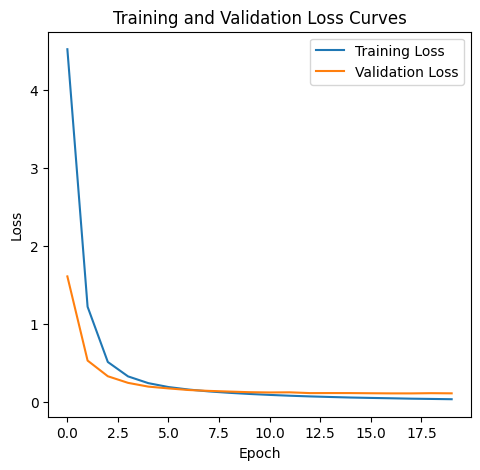

In [56]:
from timeit import default_timer as timer
best_val_loss = float("inf")
history = {
    "train": {
        "loss": [],
    },
    "valid": {
        "loss": [],
    },
}

for epoch in range(1, epochs+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, train_loader)
    end_time = timer()
    val_loss = evaluate(transformer, valid_loader)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    history["train"]["loss"].append(train_loss)
    history["valid"]["loss"].append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_file = {
            "model": transformer.state_dict(),
        }
        torch.save(save_file, "model/checkpoint.pth")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), history["train"]["loss"], label='Training Loss')
plt.plot(range(epochs), history["valid"]["loss"], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.savefig("plot/learning_curve.png")
plt.show()

# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [58]:
test_data = pd.read_csv("data/test-ZH-nospace.csv")
zh_test_list = []
for i in range(test_data.shape[0]):
    zh_test_list.append(zh_single_word_tokenize(test_data["txt"][i]))

tl_test_list = []
for i in range(len(zh_test_list)):
    tl_test_list.append(translate(transformer, zh_test_list[i]))

In [59]:
import copy
output = copy.deepcopy(test_data)
output['txt'] = tl_test_list
output.to_csv(f"output/transformer_{epochs}.csv", index=False)